# RNN POS Assignment

# Preprocess of our Dataset & Short Data Exploration (Distribution Plots)
- ### Preprocessing Steps for POS Tagging

1. **Download & Process CoNLL-U Data**
   - Fetches **train, validation, and test datasets** from Universal Dependencies.
   - Extracts **words and POS tags** from each sentence.
   - Stores sentences and corresponding POS tags in a **Pandas DataFrame**.

2. **Create Vocabulary & Word Embeddings**
   - Builds a **word vocabulary** (`word_vocab`) with `PAD` and `UNK` tokens.
   - Constructs a **POS tag vocabulary** (`pos_vocab`) with `PAD` token.
   - Loads **FastText embeddings** (`cc.en.300.bin`) and initializes an **embedding matrix**.
   - Assigns **pretrained embeddings** to known words, random vectors to unknown words.

3. **Prepare Dataset & DataLoader**
   - Defines `POSTaggingDataset` class:
     - Converts words and POS tags into **indexed tensors**.
     - **Pads or truncates** sequences to a fixed max length (95th percentile).
        - Sentences longer than max_length are truncated.
        - Sentences shorter than max_length are padded.
   - Creates **PyTorch DataLoaders** for train, validation, and test sets.
   - Ensures **batch processing** with shuffled training data.



In [40]:
!pip install fasttext

Loaded 12544 training sentences
Loaded 2001 validation sentences
Loaded 2077 test sentences


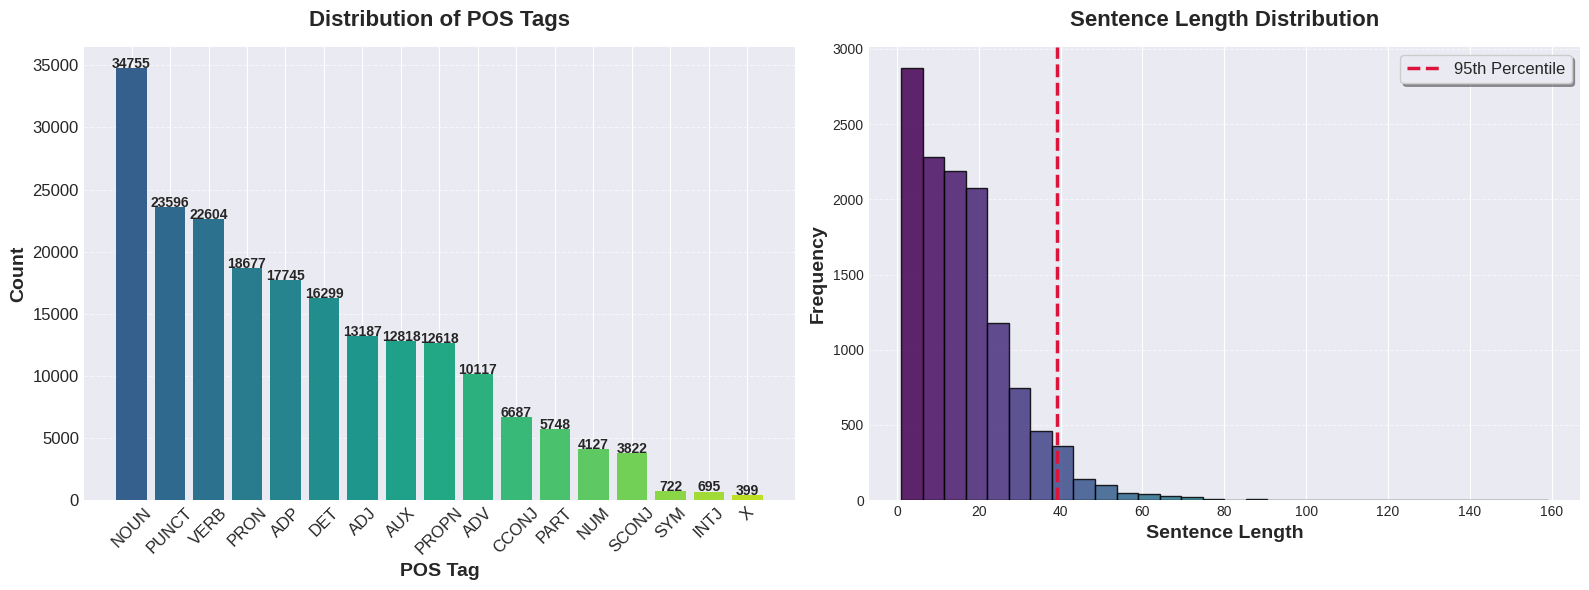

Max sentence length (95th percentile): 39
Training dataset size: 12544
Validation dataset size: 2001
Test dataset size: 2077


In [41]:
import numpy as np
import pandas as pd
import requests
import fasttext
import fasttext.util
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt

# -------------------------------
# Step 1: Download & Process CoNLL-U Data
# -------------------------------

def download_and_read_conllu(url):
    """
    Downloads and processes a CoNLL-U formatted file.
    Extracts words and POS tags from each sentence and stores them in a DataFrame.
    """
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to download file: {url}")

    data = []
    sentence, pos_tags = [], []

    for line in response.text.split("\n"):
        line = line.strip()

        # Empty line indicates the end of a sentence
        if not line:
            if sentence:
                data.append({'Sentence': sentence, 'POS_Tags': pos_tags})
                sentence, pos_tags = [], []  # Reset for the next sentence
            continue

        # Ignore comment lines
        if line.startswith('#'):
            continue

        tokens = line.split('\t')
        if len(tokens) > 3:
            word, pos_tag = tokens[1], tokens[3]
            if pos_tag not in {"_"}:
                sentence.append(word)
                pos_tags.append(pos_tag)

    if sentence:
        data.append({'Sentence': sentence, 'POS_Tags': pos_tags})

    return pd.DataFrame(data)

# Load the train, validation, and test datasets
train_url = "https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-train.conllu"
dev_url = "https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-dev.conllu"
test_url = "https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-test.conllu"

train_df = download_and_read_conllu(train_url)
dev_df = download_and_read_conllu(dev_url)
test_df = download_and_read_conllu(test_url)

print(f"Loaded {len(train_df)} training sentences")
print(f"Loaded {len(dev_df)} validation sentences")
print(f"Loaded {len(test_df)} test sentences")

# -------------------------------
# Step 1: Plot Distribution of POS Tags and Length of Setences
# -------------------------------
from collections import Counter

# Flatten the list of POS tags from all rows
all_pos_tags = [tag for sublist in train_df['POS_Tags'] for tag in sublist]

# Count occurrences of each POS tag
pos_counts = Counter(all_pos_tags)

# Sort counts in descending order for better visualization
sorted_pos_counts = dict(sorted(pos_counts.items(), key=lambda item: item[1], reverse=True))

# Compute sentence lengths
sentence_lengths = [len(sentence) for sentence in train_df["Sentence"]]

# Apply a stylish theme
plt.style.use('seaborn-v0_8-darkgrid')

# Create a figure with two side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot 1: POS Tag Distribution ---
axes[0].bar(sorted_pos_counts.keys(), sorted_pos_counts.values(),
            color=plt.cm.viridis(np.linspace(0.3, 0.9, len(sorted_pos_counts))))

axes[0].set_xlabel("POS Tag", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Count", fontsize=14, fontweight='bold')
axes[0].set_title("Distribution of POS Tags", fontsize=16, fontweight='bold', pad=15)
axes[0].tick_params(axis='x', rotation=45, labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.6)

# Show the values on top of bars
for i, (key, value) in enumerate(sorted_pos_counts.items()):
    axes[0].text(i, value + 5, str(value), ha='center', fontsize=10, fontweight='bold')

# --- Plot 2: Sentence Length Distribution ---
n, bins, patches = axes[1].hist(sentence_lengths, bins=30, edgecolor='black', alpha=0.85)

# Apply a colormap to bars
cmap = plt.cm.viridis
for i, patch in enumerate(patches):
    color = cmap(i / len(patches))  # Gradient effect
    patch.set_facecolor(color)

# Add a percentile line
percentile_95 = np.percentile(sentence_lengths, 95)
axes[1].axvline(percentile_95, color='crimson', linestyle='dashed', linewidth=2.5, label="95th Percentile")

# Improve Labels & Title
axes[1].set_xlabel("Sentence Length", fontsize=14, fontweight='bold')
axes[1].set_ylabel("Frequency", fontsize=14, fontweight='bold')
axes[1].set_title("Sentence Length Distribution", fontsize=16, fontweight='bold', pad=15)

# Customize the legend
axes[1].legend(fontsize=12, loc="upper right", frameon=True, shadow=True, fancybox=True)

# Fine-tune grid appearance
axes[1].grid(axis='y', linestyle='--', alpha=0.6, linewidth=0.7)

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plots
plt.show()

# -------------------------------
# Step 2: Create Vocabulary & Embeddings
# -------------------------------

# Create word and POS tag vocabularies
all_words = set(word.lower() for sentence in train_df["Sentence"] for word in sentence)
all_pos_tags = set(tag for tags in train_df["POS_Tags"] for tag in tags)

# Word vocabulary with 'PAD' and 'UNK'
word_vocab = {'PAD': 0, 'UNK': 1}
word_vocab.update({word: idx + 2 for idx, word in enumerate(all_words)})

# POS vocabulary with 'PAD'
pos_vocab = {'PAD': 0}
pos_vocab.update({tag: idx + 1 for idx, tag in enumerate(all_pos_tags)})

# Load FastText embeddings
fasttext.util.download_model('en', if_exists='ignore')
ft_model = fasttext.load_model('cc.en.300.bin')

# Initialize the embedding matrix
embedding_dim = 300
embedding_matrix = np.zeros((len(word_vocab), embedding_dim))

for word, idx in word_vocab.items():
    if word in ft_model:
        embedding_matrix[idx] = ft_model[word]
    elif idx > 1:
        embedding_matrix[idx] = np.random.uniform(-0.1, 0.1, embedding_dim)

# Cleanup FastText model
del ft_model

# -------------------------------
# Step 3: Prepare Dataset & DataLoader
# -------------------------------

class POSTaggingDataset(Dataset):
    """
    PyTorch Dataset for POS tagging.
    Converts sentences into indexed tensors using the word and POS vocabularies.
    """

    def __init__(self, sentences, pos_tags, word_vocab, pos_vocab, max_length):
        self.sentences = [self.tokenize(sentence, word_vocab, max_length) for sentence in sentences]
        self.pos_tags = [self.tokenize_pos(tags, pos_vocab, max_length) for tags in pos_tags]

    def tokenize(self, sentence, vocab, max_length):
        """
        Converts words to indices, pads or truncates to max_length.
        """
        tokens = [vocab.get(word.lower(), vocab['UNK']) for word in sentence]
        tokens = tokens[:max_length] + [vocab['PAD']] * max(0, max_length - len(tokens))
        return tokens

    def tokenize_pos(self, pos_tags, vocab, max_length):
        """
        Converts POS tags to indices, pads or truncates to max_length.
        """
        tokens = [vocab.get(tag, vocab['PAD']) for tag in pos_tags]
        tokens = tokens[:max_length] + [vocab['PAD']] * max(0, max_length - len(tokens))
        return tokens

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        return torch.tensor(self.sentences[idx]), torch.tensor(self.pos_tags[idx])

# Determine max sentence length using the 95th percentile
max_length = int(np.percentile([len(sentence) for sentence in train_df["Sentence"]], 95))
print(f"Max sentence length (95th percentile): {max_length}")

# Create dataset objects
train_dataset = POSTaggingDataset(train_df["Sentence"], train_df["POS_Tags"], word_vocab, pos_vocab, max_length)
val_dataset = POSTaggingDataset(dev_df["Sentence"], dev_df["POS_Tags"], word_vocab, pos_vocab, max_length)
test_dataset = POSTaggingDataset(test_df["Sentence"], test_df["POS_Tags"], word_vocab, pos_vocab, max_length)

# Create data loaders for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


In [42]:
train_loader

In [69]:
print("POS Vocabulary Mapping:", pos_vocab) # preview POS mapping


POS Vocabulary Mapping: {'PAD': 0, 'DET': 1, 'SYM': 2, 'PRON': 3, 'INTJ': 4, 'PROPN': 5, 'ADP': 6, 'NOUN': 7, 'CCONJ': 8, 'AUX': 9, 'ADJ': 10, 'PART': 11, 'ADV': 12, 'X': 13, 'PUNCT': 14, 'NUM': 15, 'VERB': 16, 'SCONJ': 17}


In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [44]:
num_pos_tags = len(pos_vocab)  # Number of POS tag classes
num_pos_tags

18

### Class for our RNN model for POS task
- ### Functionalities Supported by This RNN Model

- **Embedding Layer**
  - Supports **pretrained embeddings** (optional).
  - Can **freeze or fine-tune embeddings**.
  - Applies **dropout** after embedding.

- **RNN Architecture**
  - Supports **LSTM, GRU, or RNN** (configurable).
  - **Bidirectional mode** (optional, doubles hidden dimension).
  - Supports **multiple layers** with dropout if `num_layers > 1`.

- **Attention Mechanism** (Optional)
  - **MLP-based attention** (`Linear → Tanh → Linear`).
  - **Softmax normalization** for attention weights.
  - **Padding mask** ensures correct attention scores.
  - **Dropout applied after attention** for regularization.

- **Dropout Regularization**
  - Dropout applied **after embeddings**.
  - Dropout applied **after RNN output**.
  - Dropout applied **after attention output**.

- **Final Classification Layer**
  - Maps **hidden states to POS tag indices**.
  - Handles **both attention and non-attention cases**.

- **Flexible Design**
  - Supports **different model types (LSTM, GRU, RNN)**.
  - Configurable **dropout rate, bidirectionality, attention size**.


In [45]:
# add droput to attention too
import torch
import torch.nn as nn
import torch.nn.functional as F

class POSRNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim,
                 attention_dim=None, model_type='LSTM',
                 pretrained=True, freeze=False,
                 num_layers=1, bidirectional=True,
                 use_attention=False, dropout_rate=0.3):
        super(POSRNNModel, self).__init__()

        self.use_attention = use_attention
        scale = 2 if bidirectional else 1  # BiLSTM doubles hidden_dim
        self.dropout_rate = dropout_rate

        # Initialize Embedding Layer with Dropout
        if pretrained:
            self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0).from_pretrained(
                torch.tensor(embedding_matrix, dtype=torch.float32), freeze=freeze
            )
        else:
            self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        self.embedding_dropout = nn.Dropout(p=dropout_rate)  # Dropout after embedding

        # Select RNN Type
        rnn_class = {'RNN': nn.RNN, 'GRU': nn.GRU, 'LSTM': nn.LSTM}[model_type]
        self.rnn = rnn_class(embed_dim, hidden_dim, batch_first=True,
                             num_layers=num_layers, bidirectional=bidirectional,
                             dropout=dropout_rate if num_layers > 1 else 0)  # Dropout in RNN only if num_layers > 1

        self.rnn_dropout = nn.Dropout(p=dropout_rate)  # Dropout after RNN

        # Fully Connected Layer: Maps RNN output to POS tag indices
        self.fc = nn.Linear(scale * hidden_dim, output_dim)

        # Attention Mechanism (if enabled)
        if self.use_attention:
            assert attention_dim is not None, "Attention dimension must be specified"
            self.attention_mlp = nn.Sequential(
                nn.Linear(scale * hidden_dim, attention_dim),
                nn.Tanh(),
                nn.Linear(attention_dim, 1)
            )
            self.attention_dropout = nn.Dropout(p=dropout_rate)  # Dropout after attention

    def forward(self, x):
        """
        x: (batch_size, sequence_length)
        Output: (batch_size, sequence_length, num_pos_tags)
        """
        embedded = self.embedding(x)  # (batch_size, seq_length, embed_dim)
        embedded = self.embedding_dropout(embedded)  # Dropout on embedding

        output, _ = self.rnn(embedded)  # (batch_size, seq_length, hidden_dim * scale)
        output = self.rnn_dropout(output)  # Dropout on RNN output

        if self.use_attention:
            attention_weights = self.attention_mlp(output)  # (batch_size, seq_length, 1)

            # Mask padding positions
            padding_mask = (x == 0).unsqueeze(-1).float()  # (batch_size, seq_length, 1)
            attention_weights -= 1e6 * padding_mask  # Ignore padding tokens

            attention_weights = torch.softmax(attention_weights, dim=1)

            # Apply attention per word, preserving sequence length
            attention_output = output * attention_weights  # (batch_size, seq_length, hidden_dim * scale)
            attention_output = self.attention_dropout(attention_output)  # Dropout after attention

            pos_output = self.fc(attention_output)  # (batch_size, seq_length, num_pos_tags)

        else:
            pos_output = self.fc(output)  # (batch_size, seq_length, num_pos_tags)

        return pos_output  # Ensures correct shape for POS tagging


### Training Function Plotting both Losses and AVG Macro F1-Score for the scope of tuning
- ### Function Logic: `train_model`
- **Initialize Tracking**: Store losses, F1 scores, best model, and early stopping variables.
- **Epoch Loop** (Iterates over `epochs`):
  - **Training Phase**:
    - Set model to `train()` mode.
    - Loop over `train_loader`, move data to `device`.
    - Compute predictions, loss, backpropagate, and optimize.
    - Store non-padding token predictions for F1 score calculation.
  - **Validation Phase**:
    - Set model to `eval()` mode (no gradients).
    - Compute loss and F1 score on `val_loader`.
  - **Early Stopping**:
    - Save model if validation loss improves.
    - Stop training if no improvement for `patience` epochs.
- **Plot Results**:
  - Loss and F1 Score vs Epochs.
- **Return** training and validation losses.


In [46]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, patience=5, device='cuda'):
    train_losses, val_losses = [], []
    train_f1_scores, val_f1_scores = [], []
    best_val_loss = float('inf')
    best_model_path = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        y_true_train, y_pred_train = [], []

        for sentences, pos_tags in train_loader:
            optimizer.zero_grad()
            sentences, pos_tags = sentences.to(device), pos_tags.to(device)
            outputs = model(sentences)
            loss = criterion(outputs.permute(0, 2, 1), pos_tags)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            preds = torch.argmax(outputs, dim=2)
            for true_tags, pred_tags in zip(pos_tags.cpu().tolist(), preds.cpu().tolist()):
                for t, p in zip(true_tags, pred_tags):
                    if t != 0:
                        y_true_train.append(t)
                        y_pred_train.append(p)

        train_losses.append(train_loss / len(train_loader))
        train_f1_scores.append(f1_score(y_true_train, y_pred_train, average='macro', zero_division=0))

        model.eval()
        val_loss = 0
        y_true_val, y_pred_val = [], []
        with torch.no_grad():
            for sentences, pos_tags in val_loader:
                sentences, pos_tags = sentences.to(device), pos_tags.to(device)
                outputs = model(sentences)
                loss = criterion(outputs.permute(0, 2, 1), pos_tags)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=2)
                for true_tags, pred_tags in zip(pos_tags.cpu().tolist(), preds.cpu().tolist()):
                    for t, p in zip(true_tags, pred_tags):
                        if t != 0:
                            y_true_val.append(t)
                            y_pred_val.append(p)

        val_losses.append(val_loss / len(val_loader))
        val_f1_scores.append(f1_score(y_true_val, y_pred_val, average='macro', zero_division=0))

        print(f'Epoch {epoch+1}/{epochs} | Training Loss: {train_losses[-1]:.5f}, Validation Loss: {val_losses[-1]:.5f}, F1-Macro Train: {train_f1_scores[-1]:.5f}, F1-Macro Dev: {val_f1_scores[-1]:.5f}')

        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            patience_counter = 0
            new_model_path = f'pos_best_model_epoch_{epoch+1}.pth'
            if best_model_path is not None:
                os.remove(best_model_path)
            torch.save(model.state_dict(), new_model_path)
            best_model_path = new_model_path
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs. No improvement in validation loss for {patience} consecutive epochs.")
            break

    # Plot losses and F1-macro scores
    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot losses
    axes[0].plot(train_losses, linestyle='--', marker='o', label='Train Loss', color='blue')
    axes[0].plot(val_losses, marker='s', label='Validation Loss', color='red')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Train vs Validation Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Plot F1-macro scores
    axes[1].plot(train_f1_scores, linestyle='--', marker='o', label='Train F1-Macro', color='green')
    axes[1].plot(val_f1_scores, marker='s', label='Validation F1-Macro', color='orange')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('F1-Macro Score')
    axes[1].set_title('Train vs Validation F1-Macro Score')
    axes[1].legend()
    axes[1].grid(True)

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

    return train_losses, val_losses


### Tuning Stage : Investigation of Promising Hyperparameters.
- In order to decide the "most" promising combination of hyperparameters we check 3 diamensions :     
1. **Loss** Plot of training - dev sets we want a) the lowest loss values b) the lowest gap (in order to avoid overfitting phenomenos)
2. We monitor **macro f1 score** as an indicator of good predictions. We want high values for better predictions.

### Hidden Layer 128 + Num Layer 1 + Dropout 0.3 + Attention + Bidirectional + LSTM

Training POS tagging model...
Epoch 1/100 | Training Loss: 2.33375, Validation Loss: 1.95356, F1-Macro Train: 0.09302, F1-Macro Dev: 0.14052
Epoch 2/100 | Training Loss: 1.84286, Validation Loss: 1.64593, F1-Macro Train: 0.19769, F1-Macro Dev: 0.25005
Epoch 3/100 | Training Loss: 1.59609, Validation Loss: 1.47272, F1-Macro Train: 0.25555, F1-Macro Dev: 0.27144
Epoch 4/100 | Training Loss: 1.42989, Validation Loss: 1.35316, F1-Macro Train: 0.28890, F1-Macro Dev: 0.29207
Epoch 5/100 | Training Loss: 1.29267, Validation Loss: 1.25472, F1-Macro Train: 0.32073, F1-Macro Dev: 0.32110
Epoch 6/100 | Training Loss: 1.17867, Validation Loss: 1.17449, F1-Macro Train: 0.34403, F1-Macro Dev: 0.33162
Epoch 7/100 | Training Loss: 1.08174, Validation Loss: 1.11184, F1-Macro Train: 0.36154, F1-Macro Dev: 0.35591
Epoch 8/100 | Training Loss: 0.98545, Validation Loss: 0.97637, F1-Macro Train: 0.44030, F1-Macro Dev: 0.46531
Epoch 9/100 | Training Loss: 0.82074, Validation Loss: 0.84191, F1-Macro Train: 0.

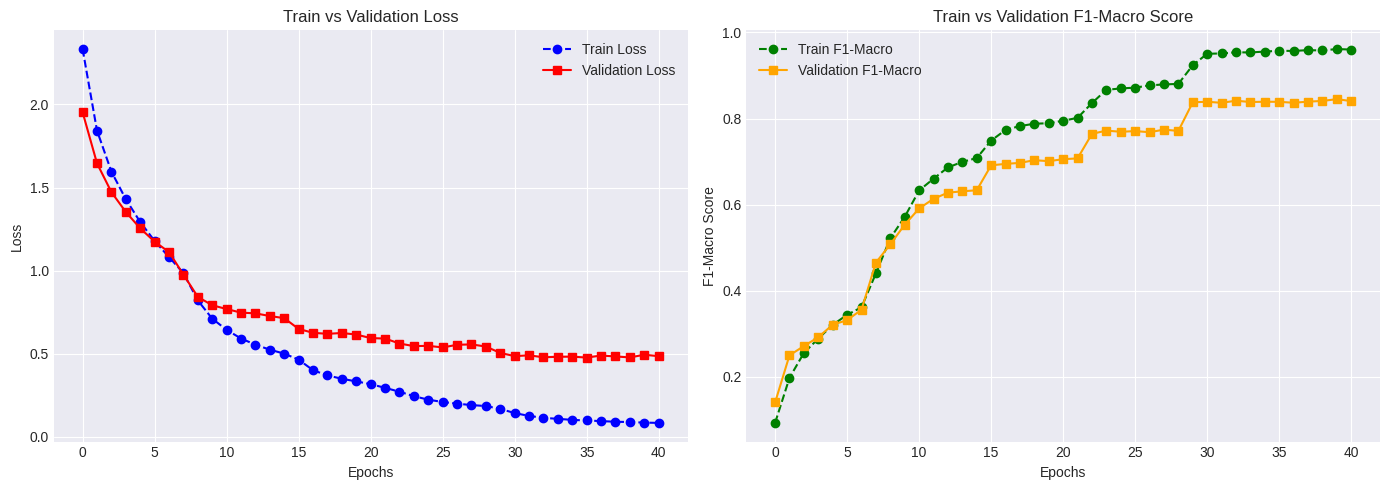

Best model at Epoch 36, Validation Loss: 0.47677


In [47]:
pos_model = POSRNNModel(
    vocab_size=len(word_vocab),
    embed_dim=300,
    hidden_dim=128,
    output_dim=num_pos_tags,
    attention_dim=32,
    model_type='LSTM',
    pretrained=True,
    freeze=False,
    num_layers=1, # no stack layers
    bidirectional=True,
    use_attention=True,
    dropout_rate=0.3  # Increased dropout to prevent overfitting
).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=pos_vocab['PAD'])
optimizer = optim.Adam(pos_model.parameters(), lr=0.0005, weight_decay=1e-5)  # Lower LR + weight decay

# Apply learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

# Train the model
epochs = 100
patience = 5
print("Training POS tagging model...")
train_losses, val_losses = train_model(
    pos_model, train_loader, val_loader, criterion, optimizer, epochs=epochs, device=device, patience=patience
)

# Find the best epoch
best_epoch = np.argmin(val_losses) + 1
print(f"Best model at Epoch {best_epoch}, Validation Loss: {min(val_losses):.5f}")

### Hidden Dim 128 + Num Layers 2 + Dropout 0.4 + Attention + Bidirectionsl + LSTM
### Key Configurations

- **`hidden_dim=128`** → Reduced hidden size to balance performance and efficiency.
- **`num_layers=2`** → Stacked LSTM layers for capturing complex dependencies.
- **`dropout_rate=0.4`** → Increased dropout to prevent overfitting.
- **`bidirectional=True`** → BiLSTM captures both forward and backward context.
- **`use_attention=True`** → Enables attention mechanism for better feature weighting.
- **`lr=0.0005` (Adam Optimizer)** → Lower learning rate for stable training.
- **`weight_decay=1e-5`** → Regularization to prevent overfitting.
- **`StepLR(step_size=5, gamma=0.8)`** → Reduces learning rate every 5 epochs for fine-tuning.
- **`patience=5` (Early Stopping)** → Stops training if validation loss doesn’t improve for 5 epochs.


Training POS tagging model...
Epoch 1/100 | Training Loss: 2.39771, Validation Loss: 1.99183, F1-Macro Train: 0.07245, F1-Macro Dev: 0.11853
Epoch 2/100 | Training Loss: 1.84929, Validation Loss: 1.58075, F1-Macro Train: 0.19402, F1-Macro Dev: 0.25367
Epoch 3/100 | Training Loss: 1.52256, Validation Loss: 1.35317, F1-Macro Train: 0.28496, F1-Macro Dev: 0.30888
Epoch 4/100 | Training Loss: 1.31154, Validation Loss: 1.22447, F1-Macro Train: 0.33431, F1-Macro Dev: 0.34119
Epoch 5/100 | Training Loss: 1.13933, Validation Loss: 1.04384, F1-Macro Train: 0.40660, F1-Macro Dev: 0.45397
Epoch 6/100 | Training Loss: 0.94886, Validation Loss: 0.92660, F1-Macro Train: 0.50004, F1-Macro Dev: 0.49529
Epoch 7/100 | Training Loss: 0.82168, Validation Loss: 0.85785, F1-Macro Train: 0.53452, F1-Macro Dev: 0.50441
Epoch 8/100 | Training Loss: 0.73894, Validation Loss: 0.81016, F1-Macro Train: 0.56113, F1-Macro Dev: 0.53090
Epoch 9/100 | Training Loss: 0.67889, Validation Loss: 0.78325, F1-Macro Train: 0.

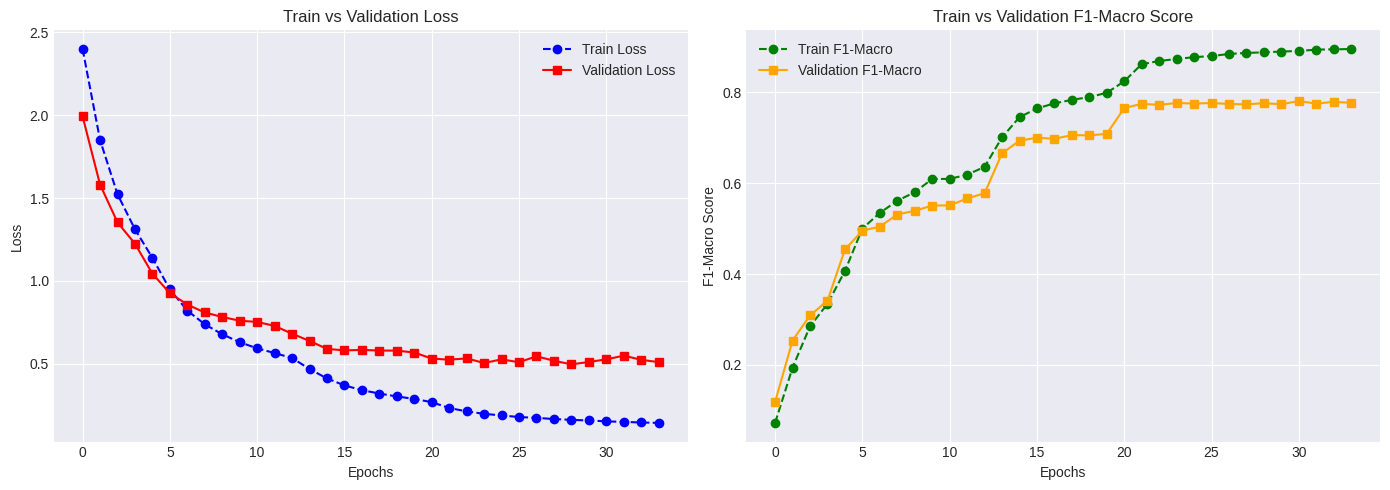

Best model at Epoch 29, Validation Loss: 0.49750


In [48]:
# Instantiate the model with optimized dropout
pos_model = POSRNNModel(
    vocab_size=len(word_vocab),
    embed_dim=300,
    hidden_dim=128,
    output_dim=num_pos_tags,
    attention_dim=32,
    model_type='LSTM',
    pretrained=True,
    freeze=False,
    num_layers=2,
    bidirectional=True,
    use_attention=True,
    dropout_rate=0.4  # Increased dropout to prevent overfitting
).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=pos_vocab['PAD'])
optimizer = optim.Adam(pos_model.parameters(), lr=0.0005, weight_decay=1e-5)  # Lower LR + weight decay

# Apply learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

# Train the model
epochs = 100
patience = 5
print("Training POS tagging model...")
train_losses, val_losses = train_model(
    pos_model, train_loader, val_loader, criterion, optimizer, epochs=epochs, device=device, patience=patience
)

# Find the best epoch
best_epoch = np.argmin(val_losses) + 1
print(f"Best model at Epoch {best_epoch}, Validation Loss: {min(val_losses):.5f}")

### Hidden Dim 256 + Num Layers 2 + Dropout 0.4 + Attention + Bidirectionsl + LSTM
### Key Configurations

- **`hidden_dim=256`** → Increased to enhance model capacity.
- **`num_layers=2`** → A stacked LSTM to capture more complex patterns.
- **`dropout_rate=0.4`** → Higher dropout to prevent overfitting.
- **`bidirectional=True`** → BiLSTM improves POS prediction by considering both left & right context.
- **`use_attention=True`** → Uses attention mechanism to focus on important words.


Training POS tagging model...
Epoch 1/100 | Training Loss: 2.31213, Validation Loss: 1.77052, F1-Macro Train: 0.08879, F1-Macro Dev: 0.19870
Epoch 2/100 | Training Loss: 1.59662, Validation Loss: 1.35599, F1-Macro Train: 0.25411, F1-Macro Dev: 0.30053
Epoch 3/100 | Training Loss: 1.26198, Validation Loss: 1.06614, F1-Macro Train: 0.37897, F1-Macro Dev: 0.44386
Epoch 4/100 | Training Loss: 0.97347, Validation Loss: 0.92432, F1-Macro Train: 0.48904, F1-Macro Dev: 0.49255
Epoch 5/100 | Training Loss: 0.81621, Validation Loss: 0.83466, F1-Macro Train: 0.55479, F1-Macro Dev: 0.53331
Epoch 6/100 | Training Loss: 0.72177, Validation Loss: 0.78939, F1-Macro Train: 0.59472, F1-Macro Dev: 0.54901
Epoch 7/100 | Training Loss: 0.63005, Validation Loss: 0.68193, F1-Macro Train: 0.64333, F1-Macro Dev: 0.61234
Epoch 8/100 | Training Loss: 0.51461, Validation Loss: 0.63111, F1-Macro Train: 0.68201, F1-Macro Dev: 0.62594
Epoch 9/100 | Training Loss: 0.45050, Validation Loss: 0.57735, F1-Macro Train: 0.

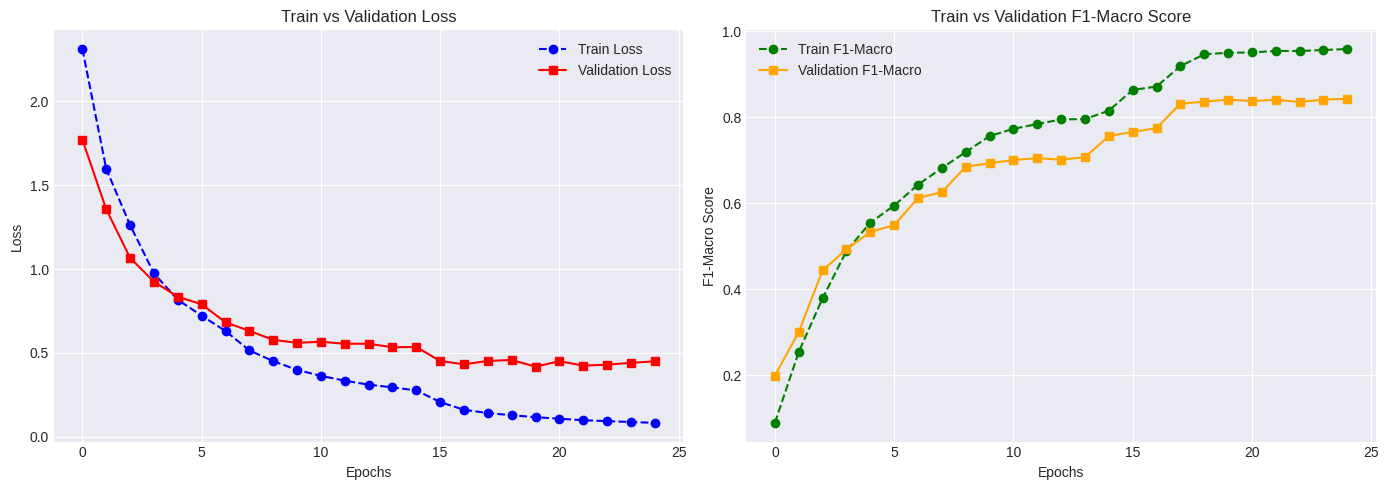

Best model at Epoch 20, Validation Loss: 0.41739


In [49]:
# Instantiate the model with optimized hidden dim
pos_model = POSRNNModel(
    vocab_size=len(word_vocab),
    embed_dim=300,
    hidden_dim=256, # increase
    output_dim=num_pos_tags,
    attention_dim=32,
    model_type='LSTM',
    pretrained=True,
    freeze=False,
    num_layers=2,
    bidirectional=True,
    use_attention=True,
    dropout_rate=0.4  # constant dropout to prevent overfitting
).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=pos_vocab['PAD'])
optimizer = optim.Adam(pos_model.parameters(), lr=0.0005, weight_decay=1e-5)  # Lower LR + weight decay

# Apply learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

# Train the model
epochs = 100
patience = 5
print("Training POS tagging model...")
train_losses, val_losses = train_model(
    pos_model, train_loader, val_loader, criterion, optimizer, epochs=epochs, device=device, patience=patience
)

# Find the best epoch
best_epoch = np.argmin(val_losses) + 1
print(f"Best model at Epoch {best_epoch}, Validation Loss: {min(val_losses):.5f}")

### Comparison of Results to  find the most promissing hyperparametr combination
- The last model having **256** hidden dim is the most promissing as it has the lowest loss value, the lowest gap between train and dev loss and the hisghest values in avg macro average. In addition, based on f1 macro avg outperforms the corresponding values of our MLP assignment of the previous task and out majority baseline.

### Train And Evaluate with put most promising combination stemming from tuning

In [89]:
def plot_metrics(train_losses, val_losses, train_metrics, val_metrics):
    """
    Plots training and validation loss, as well as macro F1-score.
    """

    """
    Plots training and validation loss, as well as macro F1-score.
    """
    train_f1 = [m["macro_f1"] for m in train_metrics]
    val_f1 = [m["macro_f1"] for m in val_metrics]
    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    train_f1 = [m["macro_f1"] for m in train_metrics]
    val_f1 = [m["macro_f1"] for m in val_metrics]
    # Plot losses
    axes[0].plot(train_losses, linestyle='--', marker='o', label='Train Loss', color='blue')
    axes[0].plot(val_losses, marker='s', label='Validation Loss', color='red')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Train vs Validation Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Plot F1-macro scores
    axes[1].plot(train_f1, linestyle='--', marker='o', label='Train F1-Macro', color='green')
    axes[1].plot(val_f1, marker='s', label='Validation F1-Macro', color='orange')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('F1-Macro Score')
    axes[1].set_title('Train vs Validation F1-Macro Score')
    axes[1].legend()
    axes[1].grid(True)

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

In [90]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, classification_report, precision_recall_curve, auc
import numpy as np

def train_and_evaluate_model(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs=10, patience=5, device='cuda'):
    train_losses, val_losses = [], []
    train_metrics, val_metrics, test_metrics = [], [], []
    best_val_loss = float('inf')
    best_model_path = None
    patience_counter = 0

    label_mapping = {
        1: 'DET', 2: 'SYM', 3: 'PRON', 4: 'INTJ', 5: 'PROPN',
        6: 'ADP', 7: 'NOUN', 8: 'CCONJ', 9: 'AUX', 10: 'ADJ', 11: 'PART',
        12: 'ADV', 13: 'X', 14: 'PUNCT', 15: 'NUM', 16: 'VERB', 17: 'SCONJ'
    }

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        y_true_train, y_pred_train = [], []

        for sentences, pos_tags in train_loader:
            optimizer.zero_grad()
            sentences, pos_tags = sentences.to(device), pos_tags.to(device)
            outputs = model(sentences)
            loss = criterion(outputs.permute(0, 2, 1), pos_tags)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            preds = torch.argmax(outputs, dim=2)
            for true_tags, pred_tags in zip(pos_tags.cpu().tolist(), preds.cpu().tolist()):
                for t, p in zip(true_tags, pred_tags):
                    if t != 0:
                        y_true_train.append(t)
                        y_pred_train.append(p)

        train_losses.append(train_loss / len(train_loader))
        train_metrics.append(compute_metrics(y_true_train, y_pred_train))

        model.eval()
        val_loss = 0
        y_true_val, y_pred_val = [], []

        with torch.no_grad():
            for sentences, pos_tags in val_loader:
                sentences, pos_tags = sentences.to(device), pos_tags.to(device)
                outputs = model(sentences)
                loss = criterion(outputs.permute(0, 2, 1), pos_tags)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=2)
                for true_tags, pred_tags in zip(pos_tags.cpu().tolist(), preds.cpu().tolist()):
                    for t, p in zip(true_tags, pred_tags):
                        if t != 0:
                            y_true_val.append(t)
                            y_pred_val.append(p)

        val_losses.append(val_loss / len(val_loader))
        val_metrics.append(compute_metrics(y_true_val, y_pred_val))

        print(f'Epoch {epoch+1}/{epochs} | '
              f'Train Loss: {train_losses[-1]:.5f}, Val Loss: {val_losses[-1]:.5f}, '
              f'Train F1-Macro: {train_metrics[-1]["macro_f1"]:.5f}, '
              f'Val F1-Macro: {val_metrics[-1]["macro_f1"]:.5f}')

        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            patience_counter = 0
            new_model_path = f'pos_best_model_epoch_{epoch+1}.pth'
            if best_model_path is not None:
                os.remove(best_model_path)
            torch.save(model.state_dict(), new_model_path)
            best_model_path = new_model_path
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs. No improvement in validation loss for {patience} epochs.")
            break

    plot_metrics(train_losses, val_losses, train_metrics, val_metrics)

    model.load_state_dict(torch.load(best_model_path))
    model.eval()
    y_true_test, y_pred_test = [], []

    with torch.no_grad():
        for sentences, pos_tags in test_loader:
            sentences, pos_tags = sentences.to(device), pos_tags.to(device)
            outputs = model(sentences)
            preds = torch.argmax(outputs, dim=2)
            for true_tags, pred_tags in zip(pos_tags.cpu().tolist(), preds.cpu().tolist()):
                for t, p in zip(true_tags, pred_tags):
                    if t != 0:
                        y_true_test.append(t)
                        y_pred_test.append(p)

    test_metrics = compute_metrics(y_true_test, y_pred_test)

    print_metrics(train_metrics[-1], y_true_train, y_pred_train, dataset_name="Train Set", label_mapping=label_mapping)
    print_metrics(val_metrics[-1], y_true_val, y_pred_val, dataset_name="Validation Set", label_mapping=label_mapping)
    print_metrics(test_metrics, y_true_test, y_pred_test, dataset_name="Test Set", label_mapping=label_mapping)

    return train_losses, val_losses, train_metrics, val_metrics, test_metrics

def compute_metrics(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None, zero_division=0)
    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)

    pr_auc_scores = {}
    unique_labels = np.unique(y_true)
    for label in unique_labels:
        binary_true = np.array([1 if y == label else 0 for y in y_true])
        binary_pred = np.array([1 if y == label else 0 for y in y_pred])
        prec, rec, _ = precision_recall_curve(binary_true, binary_pred)
        pr_auc_scores[label] = auc(rec, prec) if len(rec) > 1 else 0.0

    macro_pr_auc = np.mean(list(pr_auc_scores.values()))

    return {
        "class_precision": precision.tolist(),
        "class_recall": recall.tolist(),
        "class_f1": f1.tolist(),
        "macro_precision": macro_precision,
        "macro_recall": macro_recall,
        "macro_f1": macro_f1,
        "pr_auc": pr_auc_scores,
        "macro_pr_auc": macro_pr_auc
    }

def print_metrics(metrics, y_true, y_pred, dataset_name="Dataset", label_mapping=None):
    print(f"\n-----------Prediction Scores for {dataset_name}-----------")

    filtered_y_true = [y for y in y_true if y != 0]
    filtered_y_pred = [y for t, y in zip(y_true, y_pred) if t != 0]

    valid_labels = [label_mapping[i] for i in sorted(label_mapping.keys())]
    print(classification_report(filtered_y_true, filtered_y_pred, target_names=valid_labels, zero_division=0))
    for i in sorted(label_mapping.keys()):
        if i in metrics['pr_auc']:
            class_name = label_mapping[i]
            p, r, f1 = metrics["class_precision"][i-1], metrics["class_recall"][i-1], metrics["class_f1"][i-1]
            print(f"Class {class_name}: Precision={p:.4f}, Recall={r:.4f}, F1={f1:.4f}, AUC-PR={metrics['pr_auc'].get(i, 0.0):.4f}")
    print(f"\nMacro AUC-PR: {metrics['macro_pr_auc']:.4f}")


Training POS tagging model...
Epoch 1/25 | Train Loss: 2.32353, Val Loss: 1.81691, Train F1-Macro: 0.07750, Val F1-Macro: 0.18447
Epoch 2/25 | Train Loss: 1.62931, Val Loss: 1.37967, Train F1-Macro: 0.24956, Val F1-Macro: 0.30699
Epoch 3/25 | Train Loss: 1.27011, Val Loss: 1.06979, Train F1-Macro: 0.37392, Val F1-Macro: 0.44035
Epoch 4/25 | Train Loss: 0.98299, Val Loss: 0.92209, Train F1-Macro: 0.49333, Val F1-Macro: 0.49415
Epoch 5/25 | Train Loss: 0.82357, Val Loss: 0.83736, Train F1-Macro: 0.55781, Val F1-Macro: 0.52818
Epoch 6/25 | Train Loss: 0.72587, Val Loss: 0.77895, Train F1-Macro: 0.58693, Val F1-Macro: 0.54752
Epoch 7/25 | Train Loss: 0.59910, Val Loss: 0.66613, Train F1-Macro: 0.64716, Val F1-Macro: 0.61529
Epoch 8/25 | Train Loss: 0.50596, Val Loss: 0.62480, Train F1-Macro: 0.68118, Val F1-Macro: 0.63669
Epoch 9/25 | Train Loss: 0.44896, Val Loss: 0.58944, Train F1-Macro: 0.71204, Val F1-Macro: 0.67577
Epoch 10/25 | Train Loss: 0.39772, Val Loss: 0.56614, Train F1-Macro: 

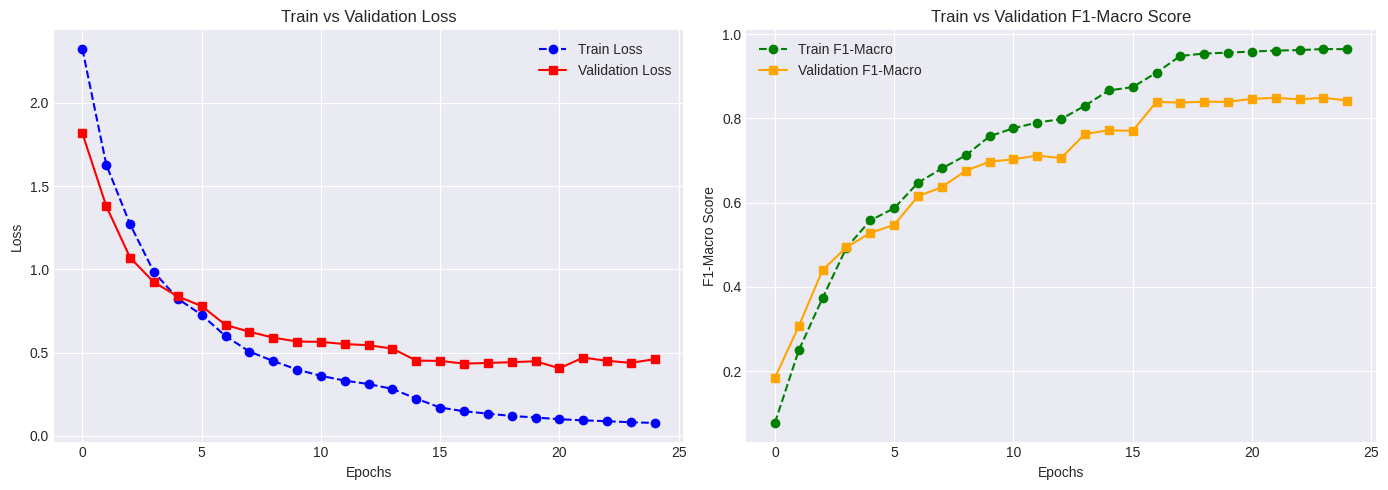

<ipython-input-90-ad1f89e2d776>:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))



-----------Prediction Scores for Train Set-----------
              precision    recall  f1-score   support

         DET       0.99      0.99      0.99     15745
         SYM       0.95      0.90      0.93       711
        PRON       0.99      0.99      0.99     18174
        INTJ       0.97      0.88      0.93       686
       PROPN       0.98      0.97      0.98     12251
         ADP       0.97      0.99      0.98     17071
        NOUN       0.99      0.99      0.99     33450
       CCONJ       0.99      1.00      0.99      6415
         AUX       0.99      0.99      0.99     12453
         ADJ       0.97      0.98      0.98     12716
        PART       0.99      0.99      0.99      5547
         ADV       0.96      0.96      0.96      9780
           X       0.96      0.69      0.80       398
       PUNCT       1.00      1.00      1.00     22426
         NUM       0.98      0.99      0.99      4060
        VERB       0.99      0.99      0.99     21889
       SCONJ       0.95   

In [91]:
# Instantiate the model promising combination
pos_model = POSRNNModel(
    vocab_size=len(word_vocab),
    embed_dim=300,
    hidden_dim=256,  # Increased hidden dim
    output_dim=num_pos_tags,
    attention_dim=32,
    model_type='LSTM',
    pretrained=True,
    freeze=False,
    num_layers=2,
    bidirectional=True,
    use_attention=True,
    dropout_rate=0.4  # Constant dropout to prevent overfitting
).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=pos_vocab['PAD'])
optimizer = optim.Adam(pos_model.parameters(), lr=0.0005, weight_decay=1e-5)  # Lower LR + weight decay

# Apply learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

# Train the model using the proper function
epochs = 25 # this defined in combination with tuning process
patience = 5

print("Training POS tagging model...")

# Call the function with all required parameters
train_losses, val_losses, train_metrics, val_metrics, test_metrics = train_and_evaluate_model(
    pos_model, train_loader, val_loader, test_loader, criterion, optimizer,
    epochs=epochs, patience=patience, device=device
)

# Find the best epoch
best_epoch = np.argmin(val_losses) + 1
print(f"Best model at Epoch {best_epoch}, Validation Loss: {min(val_losses):.5f}")

## Compare with Baselines using Majority and Optimal MLP from task 10 for comparison
- From Previous Assignment 10, where we used window 3 for POS task we found in test set the reamaining scores :
    - Accuracy (f1_score):
    - Majority Baseline = `0.86` < Optimal MLP `0.91`
    - Macro AVG (f1 score):
    - Majority Baseline = `0.80` < Optimal MLP `0.83`
- So, observing the RNN respective Test scores, we can conclude that our RNN **outpermorfms** both majority and Optimal MLP classifier as in a general view
    - RNN Accuracy F1 is `0.92` > `0.91` (Optomal MLP previous task 10 )> `0.86` (majority baseline previous task 10)
    - and RNN Macro AVG (f1 score)  is `0.86` > `0.83` (Optomal MLP previous task 10) > `0.80` (majority baseline previous task 10)